## Setup / packages / crs

In [1]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
worldmap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
usa = gp.read_file("data/cb_2018_us_nation_5m.shp")
us_states = gp.read_file("data/cb_2018_us_state_500k.shp")
ca_state = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_Counties_TIGER2016.shp")

In [4]:
# set common crs for project
projcrs = 4326
us_states = us_states.to_crs(projcrs)  # match us_states common crs for project
worldmap = worldmap.to_crs(projcrs)
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)

In [5]:
# read in Refineries

cols = list(pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", nrows =1))
refs = pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", 
                   usecols = lambda x: x not in ['other1', 'other2', 'other3', 
                                                 'other4', 'other5', 'other6', 'other7'])
refs['location'] = gp.GeoSeries.from_wkt(refs['location'])  # convert existing points to geoseries
refs = gp.GeoDataFrame(refs, geometry="location", crs=projcrs)  # convert df to geodf

In [6]:
refs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# read in cleaned and combined flares data
all_flares = gp.read_file("data/all_flares.shp")

In [ ]:
# check 
all_flares.head(3)

In [ ]:
len(all_flares)

In [ ]:
# see where the flares are across the world

fig, ax = plt.subplots(figsize = (10,8))
worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
all_flares.plot(ax = ax, color='red', markersize=1)  # increase size for visibility
plt.show()

### US / CA analysis

In [ ]:
# subset to just lower 48 plus AK
# remove territories (PR, PW, VI, MH, GU) and AK, HI
stateslist = ["AL","AR","AZ","CA","CO","CT","DC","DE","FL","GA","IA","ID", "IL","IN","KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY", "OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VA","VT","WA","WI","WV","WY"]
us_states = us_states[us_states['STUSPS'].isin(stateslist)]

In [ ]:
# match all flares and refineries with just CA counties
inner_join_result = gp.sjoin(all_flares, ca_counties, how = "inner", predicate = 'within')
refs_join = gp.sjoin(refs, ca_counties, how='inner', predicate='within')
print(f'Flares found: {len(inner_join_result)}')

In [ ]:
len(inner_join_result)

In [ ]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# calc mean by year
inner_join_result['BCM_avg'] = inner_join_result[col_list].mean(axis=1)

### Visualization

In [ ]:
# # Plotting multiple layers

fig, ax = plt.subplots(figsize = (10,8))
#worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
#us_states.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
ca_counties.plot(ax = ax, color = 'whitesmoke', edgecolor = 'grey')
# increase size by 100000 just for readability
inner_join_result.plot(ax = ax, facecolors='none', color = 'red', alpha=.2, markersize=inner_join_result[col_list].mean(axis=1)*100000)
refs_join.plot(ax = ax, facecolors = 'none', color = 'blue', alpha = .08, markersize=50)
#plt.ylim([33, 39])  # can zoom for readability
plt.title("CA methane flaring, 2012-2021")
plt.text(-119.5,41, 'flares are plotted in red,\n with transparency to show overlap\n and sized by their avg flare volume')
plt.text(-119.5,40, 'refineries are plotted in blue,\n sized arbitrarily')
plt.show()

## California: BCM by county

In [ ]:
refs

In [8]:
# just CA flares
ca_flares = gp.read_file("data/ca_flares_clean.shp")

# renaming 
ca_flares.rename(columns={'NAMELSAD':'county_name'}, inplace=True)  # old:new. Match col names for merging

print(f'Flares found: {len(ca_flares)}')

Flares found: 117


In [9]:
# Create df of total BCM by year, grouped by CA county

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

stats = ca_flares.groupby(['county_name'])[col_list].sum()
stats['Total_bcm'] = stats.loc[:,col_list].sum(axis=1)

In [10]:
stats.sort_values('Total_bcm', ascending=False)

,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,BCM_2017,BCM_2018,BCM_2019,BCM_2020,BCM_2021,Total_bcm
county_name,,,,,,,,,,,
Ventura County,0.012710,0.010459,0.014991,0.014626,0.010991,0.007965,0.013832,0.012244,0.010266,0.007006,0.115091
Kern County,0.022107,0.017479,0.006143,0.004658,0.004097,0.001750,0.001857,0.001513,0.001847,0.002424,0.063874
Contra Costa County,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016525,0.012624,0.029149
Orange County,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013800,0.002061,0.015861
Kings County,0.000113,0.000184,0.000466,0.002189,0.001324,0.000832,0.001163,0.000762,0.000651,0.000527,0.008210
Los Angeles County,0.000461,0.000566,0.000928,0.000969,0.001372,0.000441,0.000450,0.000000,0.001092,0.001398,0.007675
Fresno County,0.000000,0.000000,0.000000,0.000000,0.002157,0.000000,0.000356,0.000627,0.001563,0.002572,0.007275
Riverside County,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001856,0.000000,0.000000,0.002968,0.004824
Santa Barbara County,0.000279,0.000206,0.000099,0.000000,0.000000,0.000304,0.001694,0.000000,0.000000,0.000000,0.002583


In [11]:
forplot = stats.drop(['Total_bcm'], axis=1)
#forplot.loc['total'] = forplot.sum()

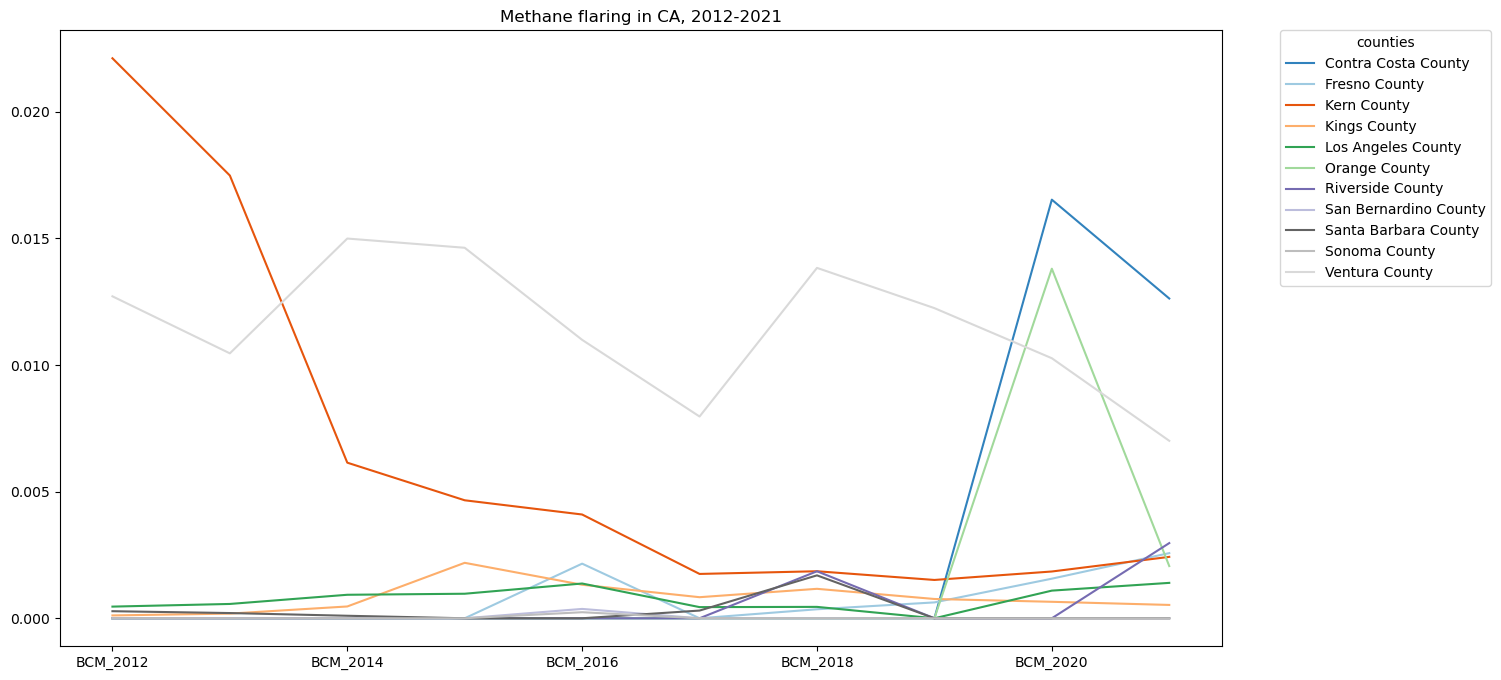

In [12]:
forplot = forplot.transpose() 

plot = forplot.plot(kind = 'line', title = 'Methane flaring in CA, 2012-2021', colormap='tab20c', figsize = [15, 8])
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='counties')

## California: BCM by flare category (upstream all, downstream oil)

In [13]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

stats = ca_flares.groupby(['flare_cate'])[col_list].sum()
stats['Total_cat'] = stats.loc[:,col_list].sum(axis=1)
stats.loc['Total'] = stats.sum()

In [14]:
# table of BCM totals by flare category and year. Ignore the meaningless value at the intersection of
# the two totals
stats

,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,BCM_2017,BCM_2018,BCM_2019,BCM_2020,BCM_2021,Total_cat
flare_cate,,,,,,,,,,,
flares_oil_downstream,0.000461,0.000566,0.000928,0.000969,0.000254,0.000441,0.000680,0.000000,0.008098,0.006118,0.018512
flares_upstream,0.035209,0.028328,0.021700,0.021474,0.020296,0.010852,0.020528,0.015145,0.037646,0.025462,0.236638
Total,0.035669,0.028893,0.022628,0.022442,0.020550,0.011293,0.021207,0.015145,0.045744,0.031579,0.255151


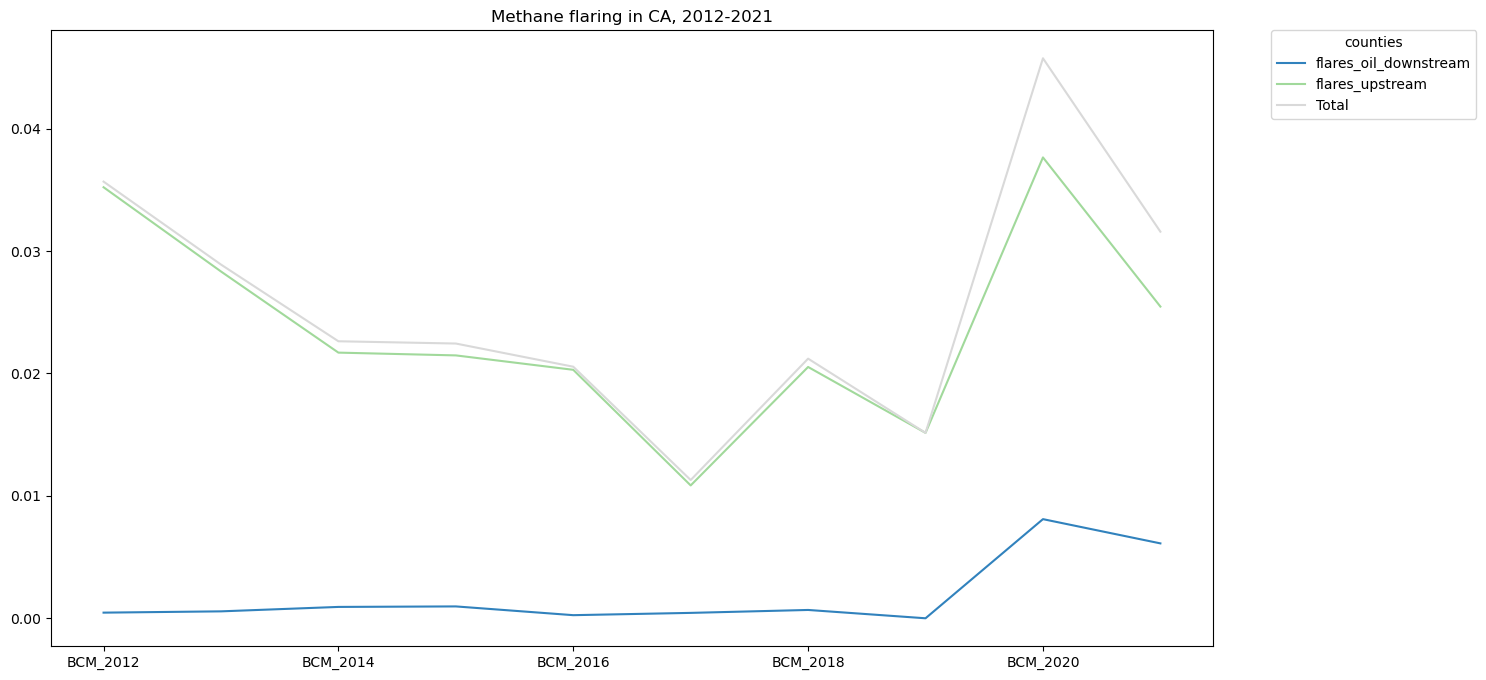

In [15]:
forplot = stats.drop(['Total_cat'], axis=1)
forplot = forplot.transpose() 

plot = forplot.plot(kind = 'line', title = 'Methane flaring in CA, 2012-2021', colormap='tab20c', figsize = [15, 8])
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='counties')

## Volume over time for individual flares

In [16]:
ca_flares.sample(1)

,Country,ISO Code,Catalog ID,id #,Latitude,Longitude,BCM_2019,avg_temp,Ellipticit,Detection_,clr_obs19,Type,ID 2020,BCM_2020,Avg. temp.,Det_freq20,clr_obs20,ID 2021,BCM_2021,Det_freq21,clr_obs21,id_key_201,Avg_Temp_K,Det_freq17,clr_obs17,ISO_Code,BCM_2017,id_key,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,clr_obs12,clr_obs13,clr_obs14,clr_obs15,clr_obs16,Det_freq12,Det_freq13,Det_freq14,Det_freq15,Det_freq16,Catalog _1,BCM_2018,Det_freq18,clr_obs18,flare_cate,Detection,Det_freq19,flare_id,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,county_name,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
30,United States,None,None,NaN,34.312565,-119.268119,NaN,NaN,2.12441,NaN,NaN,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1826.66,NaN,NaN,USA,NaN,VNF_e2012-2015_n6019_x1192681W_y343126N_v1.0,0.001224,0.000448,0.004855,0.006062,0.002192,279.0,341.0,349.0,360.0,343.0,2.15054,0.879765,8.02292,12.5,7.58017,None,NaN,NaN,NaN,flares_upstream,None,None,6295afae420679,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,POINT (67346.315 -411230.717)


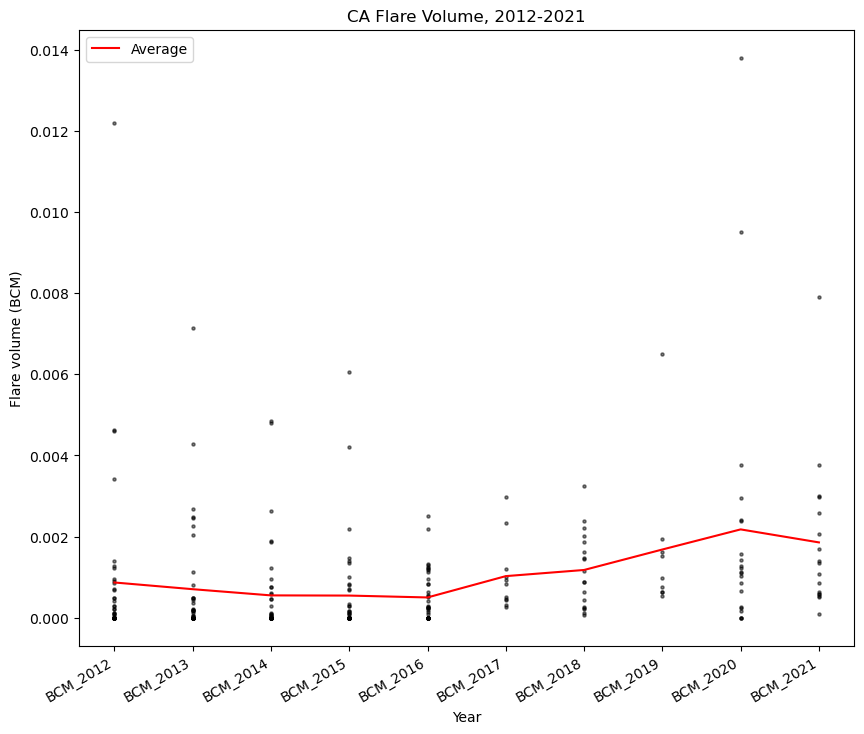

In [17]:
import matplotlib.pyplot as plt

# Define the list of columns to use
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# Create a scatterplot of flare volume values over time
fig, ax = plt.subplots(figsize=(10,8)) # Adjust the plot size
for i, year in enumerate(col_list):
    ax.scatter([i] * len(ca_flares), ca_flares[year], s=5, alpha=0.5, color='black')

# Add a trend line of the average across the whole dataframe for all years
mean_vals = ca_flares[col_list].mean(axis=0)
ax.plot(range(len(col_list)), mean_vals, color='r', label='Average')

# Set the x-axis labels to the corresponding year
ax.set_xticks(range(len(col_list)))
ax.set_xticklabels(col_list, rotation=30, ha='right')


# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Flare volume (BCM)')
ax.set_title('CA Flare Volume, 2012-2021')

# Add a legend
ax.legend()

plt.savefig('flarevol_year.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



# Attribute flares to refineries: any flare within 100m of a refinery point gets counted as part of the refinery

In [52]:
refs.sample(1)

,start_date,end_date,asset_identifier,asset_name,iso3_country,location,type,capacity,capacity_factor,activity,CO2_emissions_factor,CH4_emissions_factor,N2O_emissions_factor,other_gas_emissions_factor,CO2_emissions,CH4_emissions,N2O_emissions,other_gas_emissions,total_CO2e_100yrGWP,total_CO2e_20yrGWP,100_buff_geom
3419,1/1/2016,12/31/2016,56,Tesoro Refining & Marketing Co Anacortes,USA,POINT (-193380.970 1159706.258),NaN,119000,NaN,NaN,NaN,NaN,NaN,NaN,941685.3355,1672.512758,124.65845,NaN,981410.161,1035346.05,"POLYGON ((-193280.970 1159706.258, -193281.451..."


In [53]:
# set common crs for project
# epsg3310: https://epsg.io/3310-1739
# units: meters
meters_crs = 3310  # Projected crs. this should be good for this overlay() calculation and all of project. 

ca_flares = ca_flares.to_crs(meters_crs)
refs = refs.to_crs(meters_crs)
ca_counties = ca_counties.to_crs(meters_crs)

In [54]:
ca_refs = gp.sjoin(refs, ca_counties, how = "inner", predicate = 'within')

In [55]:
buffer_size=1000
buffer_col = f"{buffer_size}_buff_geom"
ca_refs[buffer_col] = ca_refs['location'].buffer(distance=buffer_size)

ca_refs = ca_refs.set_geometry(buffer_col)

In [59]:
ca_refs = ca_refs.drop('index_right', axis=1)

In [60]:
flares_in_refs = gp.sjoin(ca_flares, ca_refs, how = "inner", predicate = 'within')

In [61]:
len(flares_in_refs)

343

In [63]:
flares_in_refs = flares_in_refs.assign(flare_type='ref')

In [67]:
ca_flares = pd.merge(ca_flares, flares_in_refs[['flare_id', 'flare_type']], on='flare_id', how='left')
ca_flares['flare_type'] = ca_flares['flare_type'].fillna('flare') 

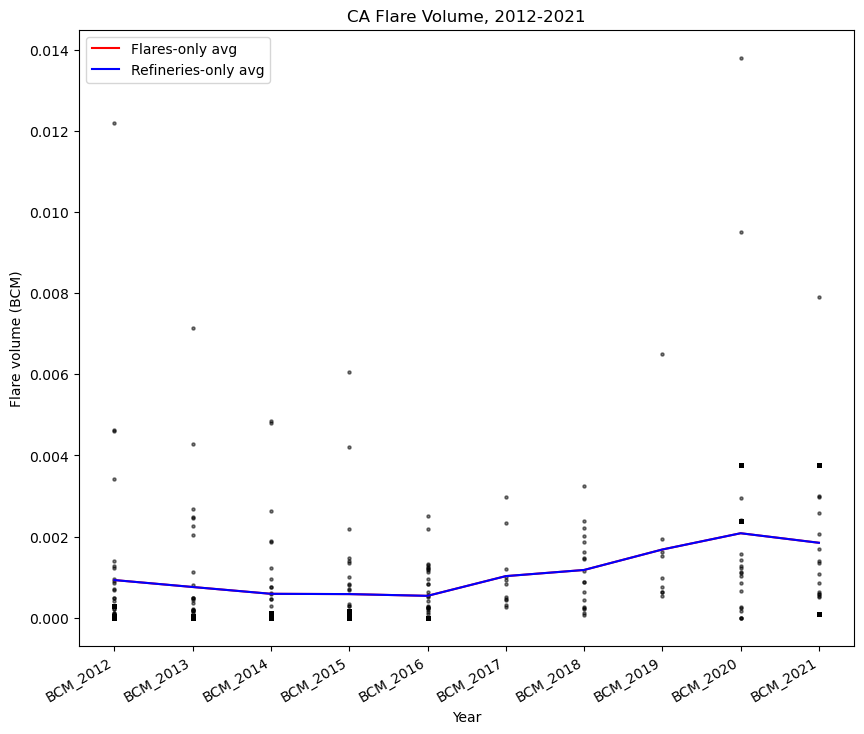

In [68]:
# Define the list of columns to use
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# Create a scatterplot of flare volume values over time
fig, ax = plt.subplots(figsize=(10,8)) # Adjust the plot size
for i, year in enumerate(col_list):
    ax.scatter([i] * len(ca_flares), ca_flares[year], s=5, alpha=0.5, color='black')

# do some filtering
flares_only_df = ca_flares[ca_flares['flare_type'] == 'flare']
refs_only_df = ca_flares[ca_flares['flare_type'] == 'ref']
  
# Add a trend line of the average across the whole dataframe for all years
mean_vals_flares = flares_only_df[col_list].mean(axis=0)
mean_vals_refs = flares_only_df[col_list].mean(axis=0)

ax.plot(range(len(col_list)), mean_vals_flares, color='r', label='Flares-only avg')
ax.plot(range(len(col_list)), mean_vals_refs, color='b', label='Refineries-only avg')


# Set the x-axis labels to the corresponding year
ax.set_xticks(range(len(col_list)))
ax.set_xticklabels(col_list, rotation=30, ha='right')


# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Flare volume (BCM)')
ax.set_title('CA Flare Volume, 2012-2021')

# Add a legend
ax.legend()

plt.savefig('flarevol_year.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()